Dataset shape: (569, 32)

Missing values per column:
id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Targe

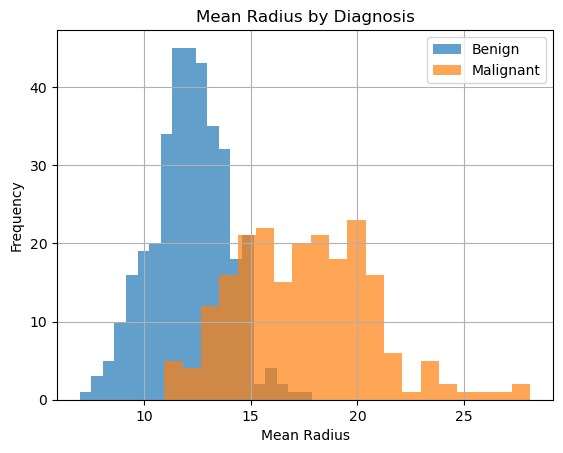


Evaluation Metrics:
Accuracy: 0.9649
F1-score: 0.95
ROC–AUC: 0.9914

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114


Top 10 Features by Permutation Importance:
texture_worst          0.075042
concavity_worst        0.065145
concavity_mean         0.060059
concave points_mean    0.042190
symmetry_worst         0.033716
texture_se             0.027865
area_worst             0.027172
radius_worst           0.019622
radius_se              0.015963
area_se                0.015709
dtype: float64


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.inspection import permutation_importance

df = pd.read_csv("data.csv") 
df = df.drop(columns=["Unnamed: 32"], errors="ignore")

print("Dataset shape:", df.shape)
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nTarget value counts:")
print(df["diagnosis"].value_counts())

print("\nTarget distribution (normalized):")
print(df["diagnosis"].value_counts(normalize=True))

plt.figure()
df["diagnosis"].value_counts().plot(kind="bar")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.title("Breast Cancer Diagnosis Distribution")
plt.show()

if "radius_mean" in df.columns:
    plt.figure()
    df[df["diagnosis"] == "B"]["radius_mean"].hist(bins=20, alpha=0.7)
    df[df["diagnosis"] == "M"]["radius_mean"].hist(bins=20, alpha=0.7)
    plt.xlabel("Mean Radius")
    plt.ylabel("Frequency")
    plt.title("Mean Radius by Diagnosis")
    plt.legend(["Benign", "Malignant"])
    plt.show()

X = df.drop(columns=["diagnosis", "id"], errors="ignore")
y = df["diagnosis"].map({"B": 0, "M": 1})  # 0 = benign, 1 = malignant

X = X.apply(pd.to_numeric)

X = X.fillna(X.median())

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

svm = SVC(
    kernel="linear",
    probability=True,
    random_state=42
)

svm.fit(X_train_scaled, y_train)

y_pred = svm.predict(X_valid_scaled)
y_proba = svm.predict_proba(X_valid_scaled)[:, 1]

acc = accuracy_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_proba)

print("\nEvaluation Metrics:")
print("Accuracy:", round(acc, 4))
print("F1-score:", round(f1, 4))
print("ROC–AUC:", round(roc_auc, 4))

print("\nClassification Report:")
print(classification_report(y_valid, y_pred))


perm = permutation_importance(
    svm,
    X_valid_scaled,
    y_valid,
    n_repeats=30,
    random_state=42,
    scoring="f1"
)

importances = pd.Series(
    perm.importances_mean,
    index=X.columns
).sort_values(ascending=False)

print("\nTop 10 Features by Permutation Importance:")
print(importances.head(10))
